In [1]:
from src.data_structures.instance import Instance
from src.solvers.DLHEU2 import DHEU
from src.data_structures.features import *
from src.solvers.collection import SolverCollection
import torch
from torch import nn
import os
from pathlib import Path
import sys
import numpy as np
import sys
import pickle
from random import shuffle
torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
def encode_bool_vec(a):
    indices = a.nonzero()
    a-= 1
    indices.T[0]
    a[indices] = 1
    return a

def decode_bool_vec(a):
    a = a + 1
    return a/2

validation_data_folder = Path("validation_data")
training_data_folder = Path("training_data")

In [3]:
key= lambda x: x.n_items
instances = list(iter(map(Instance.from_file,training_data_folder.iterdir())))
instances.sort(key=key)

evaluation_instances = list(iter(map(Instance.from_file,validation_data_folder.iterdir())))
evaluation_instances.sort(key=key)




In [4]:
features: list[ItemBatchFeature] = [
            ProfitOverBudget(),
            LowerCostOverBudget(),
            UpperCostOverBudget(),
            IsInContSol(),
            CountPSynergiesOverNItems(),
            CountPSynergiesOverBudget(),
            GammaOverNItems(),
            SumOfSynergiesByItemOverMaxSinergyProfit(),
            Noise()
            ]



In [5]:
heu = DHEU(features)

In [21]:
#heu.train(training_data_folder)
loss = []
for epoch, instance in enumerate(instances):
    x = heu.gen_x(instance).T
    y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
    if len(y) == 0: #Si la instancia no tiene solucion, no se usa :D (Las instancias mas pequeñas tienen ese riesgo)
        continue
    heu.optimizer.zero_grad()
    total_loss = 0
    y_pred = heu.net(x)
    batch_loss = heu.criterion(y_pred,y)
    batch_loss.backward()
    heu.optimizer.step()
    total_loss += batch_loss.item()
    loss.append((total_loss/2,instance))
    sys.stdout.write(f'\rEpoch {epoch},Presicion {1-(total_loss/2)} {str(instance)}')
    sys.stdout.flush()

Epoch 2183,Presicion 0.9502802105172934 Instance(2500,50,#8770764797353)

In [22]:
heu.save(Path("/home/mixto/repositories/PRKP/models/DHEUV2.model"))

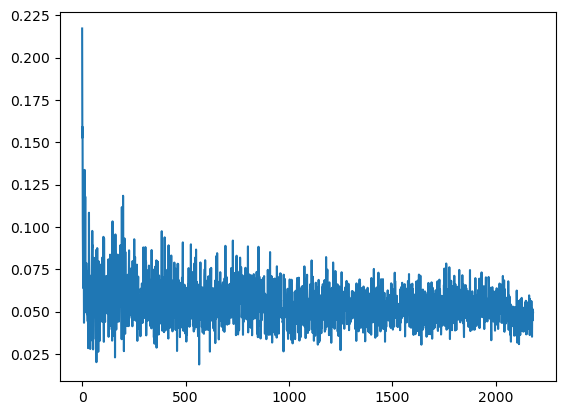

In [23]:
from matplotlib import pyplot as plt
plt.plot([i for i in range(len(loss))],[i[0] for i in loss])

In [24]:
for tupla in loss[:2000]:
    print(tupla[0],str(tupla[1]))

0.21726602634519643 Instance(100,23,#8770855079333)
0.1527341180187066 Instance(100,40,#8770853705121)
0.1591567858866171 Instance(100,62,#8770853527001)
0.10280171719993174 Instance(100,88,#8770851689745)
0.0778509004958151 Instance(100,26,#8770851345497)
0.06400721045458782 Instance(100,97,#8770851153917)
0.06653967579218664 Instance(100,92,#8770764575057)
0.09532957358245463 Instance(101,50,#8770854329073)
0.0751270963176313 Instance(101,18,#8770852555077)
0.043481453263141207 Instance(101,93,#8770851960813)
0.08057612611126592 Instance(101,81,#8770851345577)
0.10908955250538212 Instance(101,47,#8770764744741)
0.13375596822315725 Instance(102,17,#8770853314517)
0.07251696256066173 Instance(102,77,#8770850708745)
0.0706325865751866 Instance(102,80,#8770850513881)
0.11796092956391209 Instance(102,12,#8770856068105)
0.051272671207030086 Instance(103,78,#8770851345581)
0.05673503420866846 Instance(103,83,#8770764511501)
0.05716076677031594 Instance(104,97,#8770855371629)
0.0495835189848

Presicion 89.354%
STD 3.19%


(array([ 9., 39., 33.,  9.,  4.,  1.,  3.,  0.,  1.,  1.]),
 array([0.0584203 , 0.0785758 , 0.0987313 , 0.11888681, 0.13904231,
        0.15919781, 0.17935332, 0.19950882, 0.21966432, 0.23981983,
        0.25997533]),
 <BarContainer object of 10 artists>)

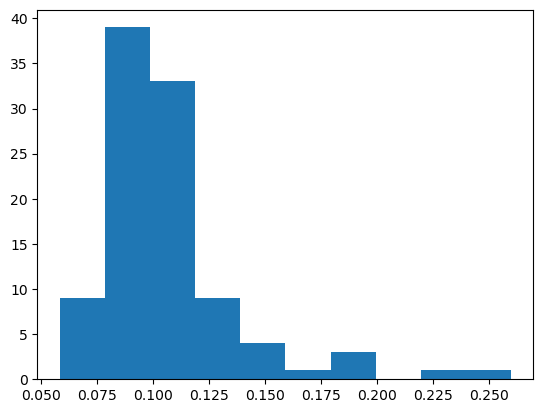

In [25]:
losses = []
with torch.no_grad():
    for instance in evaluation_instances:
        x = heu.gen_x(instance).T
        y = encode_bool_vec(instance.get_feature(IsInOptSol())).view(-1,1)
        if len(y) == 0:
            continue
        y_pred = heu.net(x)
        eval_loss = heu.criterion(y,y_pred)
        losses.append(eval_loss)
precision = (1-np.average(losses))*100
desviacion_estandar = (np.std(losses))*100
print(f"Presicion {np.round(precision,3)}%")
print(f"STD {np.round(desviacion_estandar,3)}%")

plt.hist(losses)